In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Classification with more complex models: Cross Validation,  Grid Search and Feature Importances:

Esta vez afrontaremos un problema de mayor complejidad; entrenaremos a un modelo para que sea capaz de leer números escritos y reconocerlos.

Para ello debemos emplear un modelo con una mayor complejidad y buscar una estrategia más elaborada para obtener buenos resultados. Para ello añadiremos a nuestro toolkit el cross validation y el grid search


### Cross Validation

El _cross validation_ es una estrategia alternativa al train/test split. En este caso haremos lo mismo, pero en lugar de separar el dataset de primeras entre el test y el train haremos lo siguiente:

* Separaremos el dataframe en lugar de en dos partes muy desiguales y cada uno con su objetivo definido (el train y el test) lo haremos en más partes e iguales (5 0 6)

* Ahora cogeremos una de las partes y esa hará de test y las otras cuatro de train. Una vez terminamos,  obtenemos nuestro _score_ y repetimos pero empleando otra de las partes como test y el anterior test lo metemos dentro del train.

* Una vez tenemos los 5 scores, en el caso de hacer 5 partes, hacemos la media y determinamos el score del modelo como dicha media.

Esto lo que nos permite es determinar el scoring de un modelo con mayor precisión. Como contraejemplo lo que ocurre es que vemos que, para un mismo modelo con mismos hiperparámetros, dependiendo de nuestra separación del dataset como train/test, puede variar nuestro score. Así, aplicando el CV obtenemos un resultado más realista del score del modelo.

### Grid Search CV

Grid Search CV, cv de cross validation, es una función que le aplicamos al modelo y lo que hacemos es pasarle una lista de hiperparámetros que pensamos que pueden funcionar muy bien para el modelo. Grid search básicamente lo que hará es ir probando esas combinaciones de hiperparámetros y calculando el score que obtiene con cada una de las combinaciones (que calcula mediante CV)

Luego, cuando termina, da como resultado el modelo ya entrenado con la mejor combinación posible de hiperparámetros.

In [17]:
# En este caso la base de datos la tenemos dentro de un repositorio de tensorflow:

from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

El número de abajo es un 5


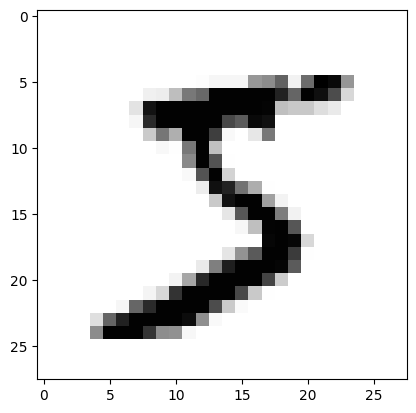

In [21]:
# Echemos un ojo a los datos:

img_index = 0 # Si cambias este número podrás ir viendo el conjunto de entrenamiento

print("El número de abajo es un {number}".format(number=str(y_train[img_index])))
plt.imshow(x_train[img_index], cmap="Greys");

In [ ]:
# Veamos cuantos pixeles tiene las imagenes y cual es su intensidad maxima:
img_resolution, img_intensity = x_train[0].shape, x_train[0].max()

print("La resolucion de las imagenes es de {res} y la intensidad maxima es de {intensity}.".format(res=(str(img_resolution)), intensity=str(img_intensity)))

La resolucion de las imagenes es de (28, 28) y la intensidad maxima es de 255.


Tal y como hemos visto, para entrenar los modelos es imprescindible normlizar sus valores numericos, en este caso basta con dividirlos entre el valor maximo de la intensidad

In [ ]:
# Normalizamos la base de datos como preprocesamiento:
x_train, x_test = x_train/img_intensity, x_test/img_intensity

# Ademas para el modelo debemos pasar las imagenes como una fila de numeros no como matrix (Deben ser elementos unidimensionales no bidimensionales):
x_train, x_test =  x_train.reshape(60000, 28*28), x_test.reshape(10000, 28*28)

### Implementar un Random Forest mediante GridSearchCV

Para ver que hiperparámetros podemos modificar dentro del random forest podemos ver la documentación, donde se enumeran y se describe cada uno de ellos:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Importamos el modelo:
random_forest = RandomForestClassifier()

In [ ]:
# Generamos el diccionario con las listas de posibles valores:
param_grid = {
    'n_estimators': [80, 100, 120],  # Número de árboles
    'max_depth': [7, 10, 15], # Máxima profundidad de los árboles
    'min_samples_split': [2, 5, 7], # Número mínimo de muestras para que se haga una separación
    # 'random_state' : [0, 132] # El estado de inicio del modelo
}

# Vamos a generar nuestro grid search:
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 12, 15],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [80, 100, 120]},
             verbose=2)

In [ ]:
# Para saber los mejores parámetros le pedimos al grid search que nos de los mejores parámetros:

print("Mejores parámetros: ", grid_search.best_params_)

Mejores parámetros:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 120}


In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_predict = grid_search.predict(x_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.94      0.94       982
           5       0.96      0.92      0.94       892
           6       0.96      0.97      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.93      0.93       974
           9       0.90      0.94      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



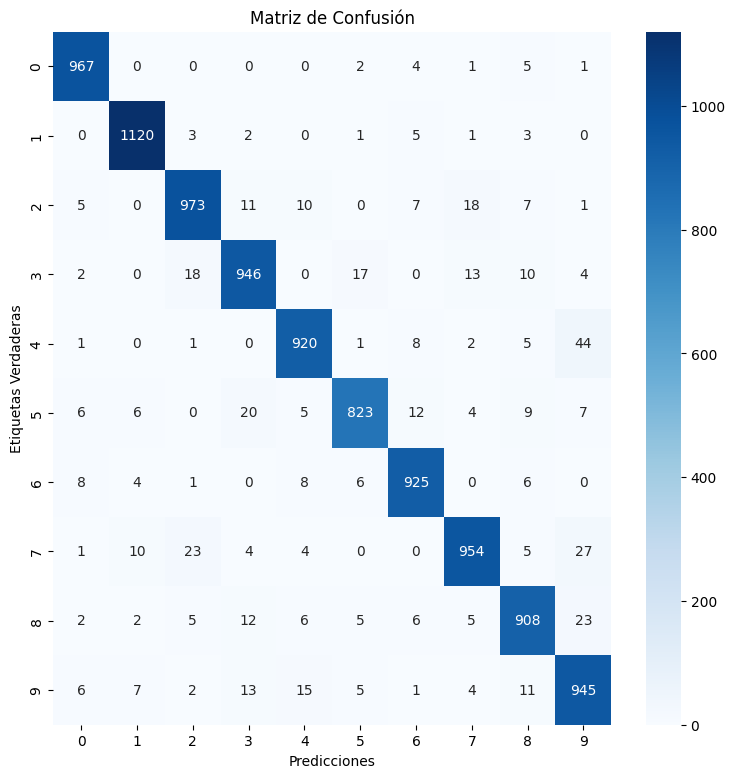

In [ ]:
# La matriz de confusión nos permite comparar lo predicho por el modelo respecto a lo que sabemos que es cierto:

conf_matrix = confusion_matrix(y_test, y_predict)

# La visualizamos mediante matplotlib y seaborn:

plt.figure(figsize=(9, 9))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10));
plt.ylabel('Etiquetas Verdaderas')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

Identifica los números que más confunde el modelo

## Features Importance

La Feature Importance es un método que contienen varios modelos, incuidos los basados en árboles como el _decision tree_ o el _random forest_ que nos permite preguntar al modelo cual han sido la importancia de cada uno de los parámetros para hacer la clasificación.

En este caso en concreto, al basarse en píxeles, carece de sentido, pero en el caso del titanic resultaría de gran ayuda dado que nos permitiría ver como afectaron los diferentes parámetros a su supervivencia.

Para emplearlo debemos aplicar sobre un modelo ya entrenado el método: modelo*.feature_importance_*.

Podemos ver su documentación para el caso del random forest dentro de:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html